In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys

import csv
import datetime
import itertools
import numpy as np
import pandas as pd
import random
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context(rc={
       "figure.figsize": (16, 10),
       "axes.titlesize": 14})

import sklearn

from IPython.display import Image, display
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

from os.path import expanduser
sys.path.insert(1, '{}/datsci'.format(expanduser('~')))
from datsci import eda
from datsci import kaggle as kg

## Generate filename lists of ImageNetDogs
downloaded from http://vision.stanford.edu/aditya86/ImageNetDogs/

```bash
for D in `find Images -type d -depth 1`; do find $D -type f > Images_filenames/`basename $D`.txt  ; done
```

## Generate deep features for dog images

```bash
filename=Images_filenames/n02106662-German_shepherd.txt
time python image_deep_features.py --image_files_listfile $filename --output_deep_features Images_features/$(basename "$filename" .txt).df.txt
```

# Read in all the deep features for every dog image

In [3]:
## Format all dogs data
def format_all_dogs_data():
    df = pd.read_csv('data/dogs_data.raw.txt', header=None)
    colnames = list(df.columns[:])
    colnames[0] = 'filepath'
    for i in range(1, len(colnames)):
	colnames[i] = "feature{}".format(colnames[i])
    df.columns = colnames
    df.to_csv('dogs_data.txt', index=False)    

In [5]:
# Load data
df = pd.read_csv('data/dogs_data.txt')
columns_deepfeatures = df.columns[1:]
df['image_name'] = df.filepath.apply(lambda x: os.path.splitext(os.path.basename(x))[0])
df['category'] = df.filepath.apply(lambda x: '-'.join(x.split('/')[1].split('-')[1:]))

In [6]:
df[["filepath", "image_name", "category"]].ix[[0,1,2]+random.sample(range(df.shape[0]), 3),]

,filepath,image_name,category
0,Images/friends-bishonfrise/bishonfrise.1.jpg,bishonfrise.1,bishonfrise
1,Images/friends-bishonfrise/bishonfrise.2.jpg,bishonfrise.2,bishonfrise
2,Images/friends-bishonfrise/bishonfrise.3.jpg,bishonfrise.3,bishonfrise
18300,Images/n02111889-Samoyed/n02111889_1438.jpg,n02111889_1438,Samoyed
12408,Images/n02104029-kuvasz/n02104029_1150.jpg,n02104029_1150,kuvasz
121,Images/n02085620-Chihuahua/n02085620_2981.jpg,n02085620_2981,Chihuahua


In [7]:
# Midpoint of all the data
middle_pt = df[columns_deepfeatures].mean()

# Sort all the points in the df with respect to their distance from middle point
df['dist_from_middle'] = df.apply(lambda row: np.linalg.norm(middle_pt.values - row[columns_deepfeatures].values), axis=1)
df_sorted = df.sort_values('dist_from_middle')

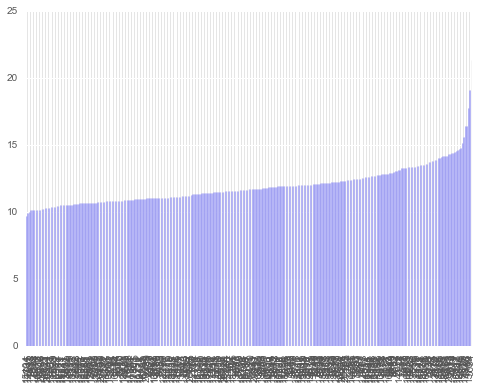

In [8]:
df.sample(300, random_state=0).dist_from_middle.sort_values().plot(kind='bar', figsize=(8,6))

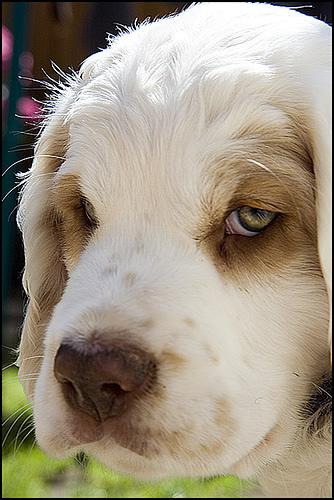

In [9]:
Image(df_sorted.iloc[10131].filepath)

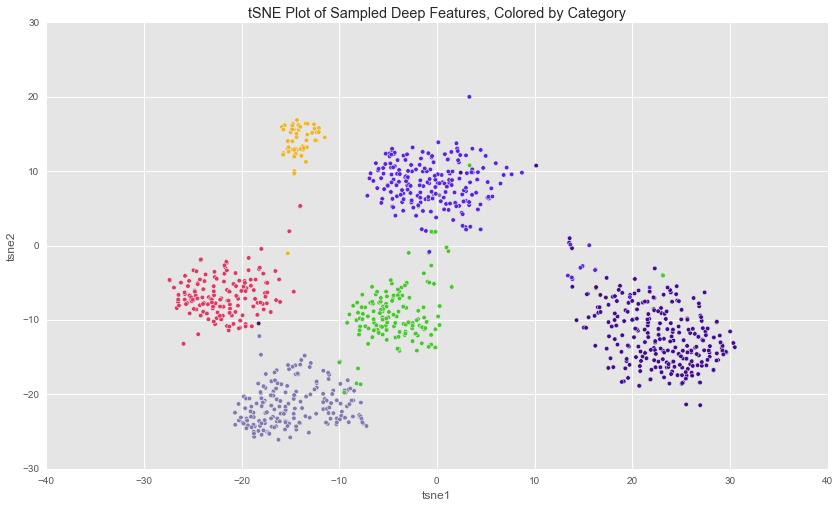

In [14]:
# Transform data w tSNE and visualize
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, random_state=0)
#df_sample = df.sample(1000, random_state=0)
df_sample = df.head(1000)
df_tsne = pd.DataFrame(tsne_model.fit_transform(df_sample[columns_deepfeatures]), columns=['tsne1', 'tsne2'])
df_tsne['category'] = df_sample.category.values

# Plot tsne data
cats = df_tsne.category.unique()[:]
cat2color = dict(zip(cats, map(lambda x: np.random.rand(3), cats)))
ax = df_tsne.plot(kind='scatter', x='tsne1', y='tsne2', c=df_tsne.category.apply(lambda x: cat2color[x]), figsize=(14, 8), title="tSNE Plot of Sampled Deep Features, Colored by Category")

# Annotate bishonfrise
#_cat = 'bishonfrise'
# _cat = 'shiba'
# for i, row in df_tsne.iterrows():
#     if row['category'] == _cat:
# 	ax.annotate(_cat, (row[0], row[1]), size=9)

Plot shows that new dogs will probably just map to known dogs that it looks like

In [11]:
from PIL import Image as PILImage

def imgshow_nearest_furthest(catname, n):
    '''Show top n images nearest and furthest from the mean'''

    df_cat = df[df.category == catname].copy(deep=True)
    middle_pt_gs = df_cat[columns_deepfeatures].mean()
    df_cat['dist_from_middle'] = df_cat.apply(lambda row: np.linalg.norm(middle_pt_gs.values - row[columns_deepfeatures].values), axis=1)
    df_cat = df_cat.sort_values('dist_from_middle')

    fig = plt.figure()
    for i in range(1, n + 1):
	ax = fig.add_subplot(1, n, i)
	plt.imshow(np.asarray(PILImage.open(df_cat.iloc[i].filepath, 'r')))
	plt.axis('off')

    fig = plt.figure()
    for i in range(1, n + 1):
	ax = fig.add_subplot(1, n, i)
	plt.imshow(np.asarray(PILImage.open(df_cat.iloc[-i].filepath, 'r')))
	plt.axis('off')

# Analyze by each category

## German Shepard

In [188]:
Image(df_gs.iloc[-7].filepath)

<IPython.core.display.Image object>

In [182]:
imgshow_nearest_furthest('German_shepherd', 7)

## Great Dane

In [183]:
imgshow_nearest_furthest('Great_Dane', 7)

## Yorkshire Terrier

In [184]:
imgshow_nearest_furthest('Yorkshire_terrier', 7)

## Siberian Husky

In [189]:
imgshow_nearest_furthest('Siberian_husky', 7)

## Toy Poodle

In [185]:
imgshow_nearest_furthest('toy_poodle', 7)

In [186]:
imgshow_nearest_furthest('shiba', 7)

In [187]:
imgshow_nearest_furthest('bishonfrise', 2)